In [1]:
import albumentations as A
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import os
import random
from collections import defaultdict
from glob import glob

In [2]:
base_path = "/kaggle/input/datasets/sgp729/dataset-1/imgs/"

In [3]:
# важно - зафиксировать все сиды
SEED = 1488
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
class_to_idx = {
  "Апельсины": 0,
  "Бананы": 1,
  "Груши": 2,
  "Кабачки": 3,
  "Капуста": 4,
  "Картофель": 5,
  "Киви": 6,
  "Лимон": 7,
  "Лук": 8,
  "Мандарины": 9,
  "Морковь": 10,
  "Огурцы": 11,
  "Томаты": 12,
  "Яблоки зелёные": 13,
  "Яблоки красные": 14
}

In [5]:
class MyDataset(Dataset):
    def __init__(self, images_filepaths, name2label,
                 base_transform=None,
                 strong_transform=None,
                 weak_classes=None):
        """
        images_filepaths: список путей или кортежей (path, label)
        name2label: словарь имя класса -> индекс (для старых данных, если paths без меток)
        Если images_filepaths содержит кортежи (path, label), то name2label игнорируется.
        """
        self.images_filepaths = images_filepaths
        self.name2label = name2label
        self.base_transform = base_transform
        self.strong_transform = strong_transform
        self.weak_classes = weak_classes or []

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        # Если images_filepaths хранит кортежи (path, label)
        if isinstance(self.images_filepaths[idx], (tuple, list)):
            image_filepath, label = self.images_filepaths[idx]
        else:
            # Старый вариант: только путь, метка из name2label
            image_filepath = self.images_filepaths[idx]
            label = self.name2label[os.path.normpath(image_filepath).split(os.sep)[-3]]

        image = cv2.imdecode(np.fromfile(image_filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Выбор подходящего pipeline
        if label in self.weak_classes:
            transform = self.strong_transform
        else:
            transform = self.base_transform

        if transform is not None:
            image = transform(image=image)['image']

        return image, label


def train_test_split_from_directory(root_path, folder2class, train_size=0.8):
    train, test = [], []
    class_to_images = defaultdict(list)

    for class_name in os.listdir(root_path):
        class_path = os.path.join(root_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for subclass_name in os.listdir(class_path):
            subclass_path = os.path.join(class_path, subclass_name)
            if not os.path.isdir(subclass_path):
                continue

            # Глобальный класс = имя первой папки (class_name)
            class_name = folder2class.get(class_name, class_name)

            images = glob(os.path.join(subclass_path, '*.jpg')) + \
                     glob(os.path.join(subclass_path, '*.png')) + \
                     glob(os.path.join(subclass_path, '*.jpeg'))

            class_to_images[class_name].extend(images)

    # Равномерное разбиение по каждому классу
    for cls_name, images in class_to_images.items():
        random.shuffle(images)
        split_idx = int(train_size * len(images))
        train.extend(images[:split_idx])
        test.extend(images[split_idx:])

    return train, test


In [6]:
dataset_path = base_path + 'train'
print(f'dataset_path({dataset_path})')
train, test = train_test_split_from_directory(dataset_path, class_to_idx, train_size=0.8)

dataset_path(/kaggle/input/datasets/sgp729/dataset-1/imgs/train)


# Посмотрим на распределение данных

In [7]:
from collections import Counter
import os

def count_classes(image_paths, class_to_idx):
    counts = Counter()
    for path in image_paths:
        class_name = os.path.normpath(path).split(os.sep)[-3]
        class_idx = class_to_idx[class_name]
        counts[class_idx] += 1
    return counts

train_counts = count_classes(train, class_to_idx)
test_counts  = count_classes(test, class_to_idx)

print(train_counts)

Counter({0: 692, 13: 673, 4: 668, 1: 641, 5: 631, 12: 605, 9: 578, 14: 574, 7: 520, 8: 500, 11: 469, 10: 467, 2: 317, 3: 237, 6: 146})


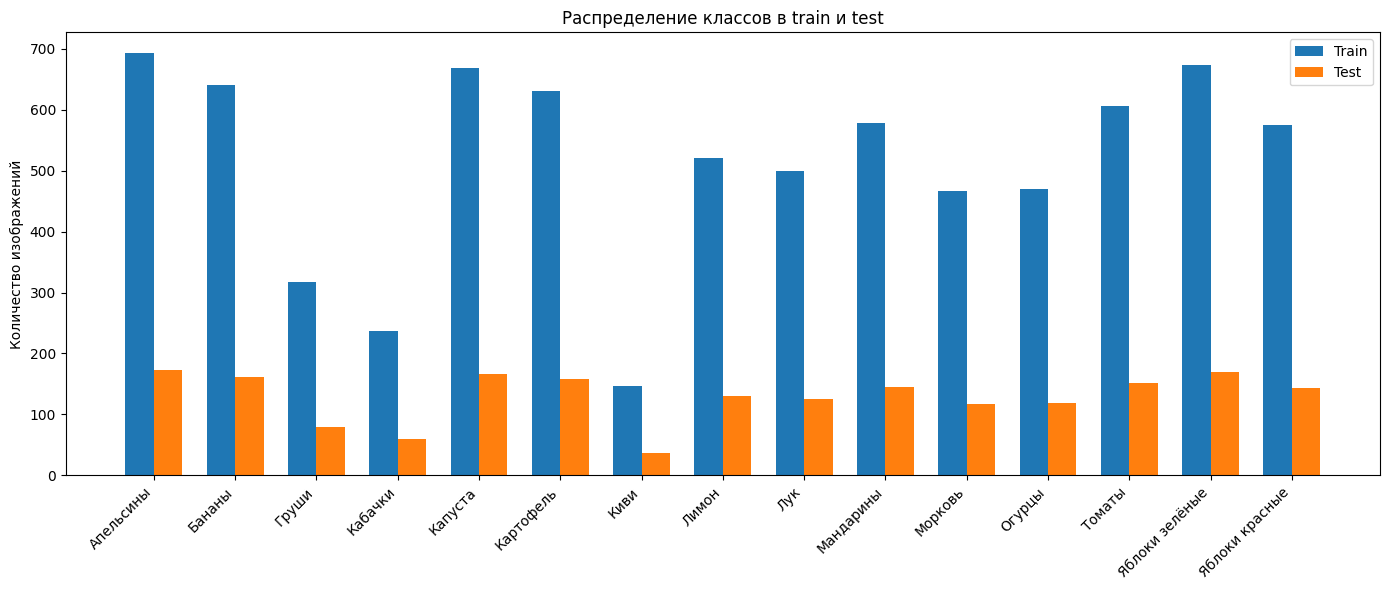

In [8]:
import matplotlib.pyplot as plt
import numpy as np

idx2class = {v: k for k, v in class_to_idx.items()}

classes = list(idx2class.keys())
class_names = [idx2class[i] for i in classes]

train_values = [train_counts.get(i, 0) for i in classes]
test_values  = [test_counts.get(i, 0) for i in classes]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, train_values, width, label='Train')
plt.bar(x + width/2, test_values,  width, label='Test')

plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel('Количество изображений')
plt.title('Распределение классов в train и test')
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

rows = []

for class_idx, class_name in idx2class.items():
    train_cnt = train_counts.get(class_idx, 0)
    test_cnt  = test_counts.get(class_idx, 0)
    total     = train_cnt + test_cnt

    test_ratio = test_cnt / total if total > 0 else 0

    rows.append({
        "Класс": class_name,
        "Train": train_cnt,
        "Test": test_cnt,
        "Total": total,
        "Test %": round(test_ratio * 100, 2)
    })

df = pd.DataFrame(rows)
df


,Класс,Train,Test,Total,Test %
0,Апельсины,692,173,865,20.00
1,Бананы,641,161,802,20.07
2,Груши,317,80,397,20.15
3,Кабачки,237,60,297,20.20
4,Капуста,668,167,835,20.00
5,Картофель,631,158,789,20.03
6,Киви,146,37,183,20.22
7,Лимон,520,131,651,20.12
8,Лук,500,125,625,20.00
9,Мандарины,578,145,723,20.06


# Вернёмся к обучению

### Аугментации

In [10]:
def create_tta_batch(x: torch.Tensor):
    # x: shape (B, C, H, W)
    tta_versions = []

    tta_versions.append(x)
    tta_versions.append(torch.flip(x, dims=[3]))
    tta_versions.append(torch.flip(x, dims=[2]))
    tta_versions.append(torch.flip(x, dims=[2, 3]))
    tta_versions.append(torch.rot90(x, k=1, dims=[2, 3]))
    tta_versions.append(torch.rot90(x, k=2, dims=[2, 3]))
    tta_versions.append(torch.rot90(x, k=3, dims=[2, 3]))

    tta_batch = torch.cat(tta_versions, dim=0) # shape: (B*n_tta, C, H, W)
    return tta_batch, len(tta_versions)

def calc_tta_logits(model, X_batch):
    tta_batch, n_tta = create_tta_batch(X_batch) # shape: (B*n_tta, C, H, W)
    logits_all = model(tta_batch)  # shape: (B*n_tta, num_classes)

    B = X_batch.size(0)

    logits_all = logits_all.view(n_tta, B, -1) # shape: (n_tta, B, num_classes)
    logits = logits_all.mean(dim=0)  # shape: (B, num_classes)
    return logits


In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---------- Индексы проблемных классов ----------
COLOR_CRITICAL = [13, 14]          # Яблоки зеленые и красные
WEAK_CLASSES = [2, 6, 8, 14]       # Груши, Киви, Лук, Яблоки красные

IMAGE_W, IMAGE_H = 224, 224

# ---------- БАЗОВЫЙ pipeline ----------
base_train_transforms = A.Compose([
    A.Resize(IMAGE_W, IMAGE_H),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.5),
    # A.CoarseDropout(max_holes=4, max_height=40, max_width=40, fill_value=0, p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])

# Усиленный pipeline для слабых классов (больше геометрии, Cutout, шум)
strong_transforms = A.Compose([
    A.Resize(IMAGE_W, IMAGE_H),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=45, p=0.7),
    # A.CoarseDropout(max_holes=8, max_height=50, max_width=50, fill_value=0, p=0.4),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])

# Для валидации оставляем без изменений (только Resize + Normalize)
val_transforms = A.Compose([
    A.Resize(IMAGE_W, IMAGE_H),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [12]:
batch_size = 64

train_dataset = MyDataset(
    images_filepaths=train,
    name2label=class_to_idx,
    base_transform=base_train_transforms,
    strong_transform=strong_transforms,
    weak_classes=WEAK_CLASSES
)

test_dataset = MyDataset(
    images_filepaths=test,
    name2label=class_to_idx,
    base_transform=val_transforms,      # для валидации используем val_transforms во всех случаях
    strong_transform=val_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=True  # Keep workers alive
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size // 2,
    shuffle=False,
    num_workers=4,
    pin_memory=True,  # Faster GPU transfer
    persistent_workers=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")

2026-02-26 19:14:52.518902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772133292.707797      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772133292.759770      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772133293.211179      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772133293.211220      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772133293.211222      55 computation_placer.cc:177] computation placer alr

In [15]:
import numpy as np
import torch
from tqdm import tqdm

@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device, desc="Val"):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(dataloader, desc=desc, leave=False)
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # logits = model(X_batch)
        logits = calc_tta_logits(model, X_batch)
        loss = loss_fn(logits, y_batch)

        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size

        y_pred = logits.argmax(dim=1)
        total_correct += (y_pred == y_batch).sum().item()
        total_samples += batch_size

        avg_loss = total_loss / max(total_samples, 1)
        acc = total_correct / max(total_samples, 1)
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.4f}")

    avg_loss = total_loss / max(total_samples, 1)
    accuracy = total_correct / max(total_samples, 1)
    return accuracy, avg_loss


def train(model, loss_fn, optimizer, scheduler, train_loader, val_loader, device, writer=None, n_epoch=10):
    num_iter = 0

    for epoch in range(1, n_epoch + 1):
        model.train()

        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epoch}", leave=True)

        for X_batch, y_batch in pbar:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # накопим метрики для прогресс-бара
            batch_size = y_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            y_pred = logits.argmax(dim=1)
            total_correct += (y_pred == y_batch).sum().item()

            avg_loss = total_loss / max(total_samples, 1)
            acc = total_correct / max(total_samples, 1)

            # tqdm live-metrics
            pbar.set_postfix(train_loss=f"{avg_loss:.4f}", train_acc=f"{acc:.4f}")

            # логирование (по итерациям)
            num_iter += 1
            if writer is not None:
                writer.add_scalar("Loss/train", loss.item(), num_iter)
                writer.add_scalar("Accuracy/train", (y_pred == y_batch).float().mean().item(), num_iter)

        # Валидация
        val_acc, val_loss = evaluate(model, val_loader, loss_fn, device, desc=f"Val {epoch}/{n_epoch}")
        
        if scheduler is not None:
            scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        if writer is not None:
            writer.add_scalar("Loss/val", val_loss, num_iter)
            writer.add_scalar("Accuracy/val", val_acc, num_iter)
            writer.add_scalar("LR", current_lr, epoch)

        print(f"Epoch {epoch}/{n_epoch}: val_loss={val_loss:.4f}  val_acc={val_acc:.4f}  lr={current_lr:.6f}")

    return model

## Три основные составляющие любого обучения:
### 1) Модель
### 2) Функция ошибок (loss function)
### 3) Оптимизатор

In [16]:
# Веса для классов с учётом дисбаланса и усилением слабых классов

num_classes = len(class_to_idx)
class_weights = torch.zeros(num_classes)

train_counts_dict = dict(train_counts)
max_count = max(train_counts_dict.values()) if train_counts_dict else 1

# Базовые веса – обратная частота
for i in range(num_classes):
    count = train_counts_dict.get(i, 0)
    if count > 0:
        class_weights[i] = max_count / count
    else:
        class_weights[i] = 0.0

print("Raw class weights (inverse frequency):", class_weights.cpu().numpy())

# Нормировка, чтобы сумма равнялась num_classes (как в исходном коде)
class_weights = class_weights / class_weights.sum() * num_classes

# Список слабых классов (низкая точность по отчёту)
WEAK_CLASSES = [2, 6, 8, 14]  # Груши, Киви, Лук, Яблоки красные
BOOST_FACTOR = 1.4  # во сколько раз увеличить вес для этих классов

for i in WEAK_CLASSES:
    class_weights[i] *= BOOST_FACTOR

# Повторная нормировка после усиления
class_weights = class_weights / class_weights.sum() * num_classes

print("Class weights after boosting weak classes:", class_weights.cpu().numpy())

class_weights = class_weights.to(device)

Raw class weights (inverse frequency): [1.        1.0795631 2.1829653 2.9198313 1.0359281 1.0966719 4.739726
 1.3307692 1.384     1.1972319 1.4817988 1.4754797 1.1438017 1.0282317
 1.2055749]
Class weights after boosting weak classes: [0.5336848  0.57614636 1.6310214  1.5582695  0.55285907 0.5852771
 3.541327   0.7102112  1.0340675  0.6389444  0.7908134  0.7874411
 0.6104295  0.54875165 0.9007557 ]


In [17]:
model = timm.create_model('tf_efficientnetv2_s', pretrained=True, num_classes=15, drop_rate=0.5)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.05)

learning_rate = 0.01
momentum = 0.9
weight_decay = 2e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

epochs = 11
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=1e-4
)

model = train(model, loss_fn, optimizer, scheduler,
              train_loader, test_loader,
              device, writer, n_epoch=epochs)

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Epoch 1/11: 100%|██████████| 121/121 [00:51<00:00,  2.33it/s, train_acc=0.6697, train_loss=1.6351]


Epoch 1/11: val_loss=0.7282  val_acc=0.8462  lr=0.010000


Epoch 2/11: 100%|██████████| 121/121 [00:49<00:00,  2.43it/s, train_acc=0.8673, train_loss=0.7231]


Epoch 2/11: val_loss=0.5830  val_acc=0.9174  lr=0.010000


Epoch 3/11: 100%|██████████| 121/121 [00:49<00:00,  2.43it/s, train_acc=0.9006, train_loss=0.6212]


Epoch 3/11: val_loss=0.5538  val_acc=0.9200  lr=0.010000


Epoch 4/11: 100%|██████████| 121/121 [00:49<00:00,  2.42it/s, train_acc=0.9260, train_loss=0.5634]


Epoch 4/11: val_loss=0.5593  val_acc=0.9210  lr=0.010000


Epoch 5/11: 100%|██████████| 121/121 [00:49<00:00,  2.43it/s, train_acc=0.9377, train_loss=0.5246]


Epoch 5/11: val_loss=0.5334  val_acc=0.9303  lr=0.010000


Epoch 6/11: 100%|██████████| 121/121 [00:49<00:00,  2.43it/s, train_acc=0.9512, train_loss=0.4973]


Epoch 6/11: val_loss=0.5120  val_acc=0.9391  lr=0.010000


Epoch 7/11: 100%|██████████| 121/121 [00:49<00:00,  2.42it/s, train_acc=0.9535, train_loss=0.4801]


Epoch 7/11: val_loss=0.4865  val_acc=0.9458  lr=0.010000


Epoch 8/11: 100%|██████████| 121/121 [00:49<00:00,  2.43it/s, train_acc=0.9680, train_loss=0.4487]


Epoch 8/11: val_loss=0.4820  val_acc=0.9510  lr=0.010000


Epoch 9/11: 100%|██████████| 121/121 [00:49<00:00,  2.43it/s, train_acc=0.9719, train_loss=0.4398]


Epoch 9/11: val_loss=0.5217  val_acc=0.9360  lr=0.010000


Epoch 10/11: 100%|██████████| 121/121 [00:49<00:00,  2.43it/s, train_acc=0.9719, train_loss=0.4317]


Epoch 10/11: val_loss=0.4877  val_acc=0.9463  lr=0.010000


Epoch 11/11: 100%|██████████| 121/121 [00:49<00:00,  2.43it/s, train_acc=0.9767, train_loss=0.4201]
                                                                                   

Epoch 11/11: val_loss=0.4700  val_acc=0.9535  lr=0.010000


# Посмотрим на итоговые метрики

In [18]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def sklearn_report(model, dataloader, device, idx2class=None, digits=4):
    model.eval()

    y_true, y_pred = [], []

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device, non_blocking=True)

        logits = calc_tta_logits(model, X_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

        y_pred.append(preds)
        y_true.append(y_batch.numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # names for report
    if idx2class is None:
        target_names = None
        labels = None
    else:
        labels = sorted(idx2class.keys())
        target_names = [idx2class[i] for i in labels]

    rep = classification_report(
        y_true, y_pred,
        labels=labels,
        target_names=target_names,
        digits=digits,
        zero_division=0
    )
    print(rep)

In [19]:
sklearn_report(model, test_loader, device, idx2class=idx2class)

                precision    recall  f1-score   support

     Апельсины     0.9706    0.9538    0.9621       173
        Бананы     0.9873    0.9689    0.9781       161
         Груши     0.9176    0.9750    0.9455        80
       Кабачки     0.9661    0.9500    0.9580        60
       Капуста     1.0000    0.9940    0.9970       167
     Картофель     0.9245    0.9304    0.9274       158
          Киви     0.9167    0.8919    0.9041        37
         Лимон     0.9528    0.9237    0.9380       131
           Лук     0.9360    0.9360    0.9360       125
     Мандарины     0.9583    0.9517    0.9550       145
       Морковь     0.9487    0.9487    0.9487       117
        Огурцы     0.9916    1.0000    0.9958       118
        Томаты     0.9490    0.9803    0.9644       152
Яблоки зелёные     0.9222    0.9822    0.9513       169
Яблоки красные     0.9259    0.8681    0.8961       144

      accuracy                         0.9535      1937
     macro avg     0.9512    0.9503    0.9505 

# Оформляем предсказание

In [20]:
test_images_dir = base_path + "test_images"
submission_path = base_path + "sample_submission.csv"
output_path = "/kaggle/working/submission.csv"

print(f'test_images_dir({test_images_dir})')
print(f'submission_path({submission_path})')

test_images_dir(/kaggle/input/datasets/sgp729/dataset-1/imgs/test_images)
submission_path(/kaggle/input/datasets/sgp729/dataset-1/imgs/sample_submission.csv)


In [21]:
submission = pd.read_csv(submission_path)

model.eval()
pred_labels = []

image_ids = submission["image_id"].tolist()

with torch.no_grad():
    for start_idx in tqdm(range(0, len(image_ids), batch_size), desc="Predicting"):
        batch_ids = image_ids[start_idx:start_idx + batch_size]
        images = []

        # Загружаем батч изображений
        for image_id in batch_ids:
            image_path = os.path.join(test_images_dir, image_id)

            image = cv2.imdecode(
                np.fromfile(image_path, dtype=np.uint8),
                cv2.IMREAD_COLOR
            )
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if val_transforms is not None:
                image = val_transforms(image=image)["image"]

            images.append(image)

        # Формируем батч
        X_batch = torch.stack(images).to(device)

        logits = calc_tta_logits(model, X_batch)
        preds = logits.argmax(dim=1).cpu().tolist()

        pred_labels.extend(preds)

Predicting: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it]


In [22]:
submission["label"] = pred_labels
submission.to_csv(output_path, index=False)

submission.head()

,image_id,label
0,fd343552326b42c5a62c192f32549dc7.jpg,2
1,445ca69812cf44f581cc8a89223af277.jpg,7
2,570626ce4d8f41edb8088f49d40a2195.jpg,7
3,02d4acba92f343d798adcb4958fe684b.jpg,11
4,2d4b8e8f38534a39b0d02c440e917b83.jpg,12


In [25]:
torch.save(model.state_dict(), '/kaggle/working/model.pt')